# Sampled 2013 NYC Taxi Trip and Fare Dataset in Spark 2.0 

#### Two machine learning problems:
1. Binary classification: Prediction of tip or no-tip (1/0) for a taxi trip [Using regularized regression]
2. Regression problem: Prediction of the tip amonut ($) [Using random forest]


In [1]:
# location of data
taxi_train_file_loc = "train.csv"
taxi_valid_file_loc = "test.csv"

# model storage directory path
modelDir = "../Outputs/"; 

In [2]:
# import libraries
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.evaluation import BinaryClassificationMetrics, RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, RFormula
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import numpy as np
import datetime
import atexit
from sklearn.metrics import roc_curve,auc

sqlContext = SQLContext(sc)

In [3]:
# read the csv data in spark df
taxi_train_df = spark.read.csv(path=taxi_train_file_loc, header=True, inferSchema=True)

# clean & normalize the daat
taxi_df_train_cleaned = taxi_train_df.drop('medallion').drop('hack_license').drop('store_and_fwd_flag').drop('pickup_datetime')\
    .drop('dropoff_datetime').drop('pickup_longitude').drop('pickup_latitude').drop('dropoff_latitude')\
    .drop('dropoff_longitude').drop('tip_class').drop('total_amount').drop('tolls_amount').drop('mta_tax')\
    .drop('direct_distance').drop('surcharge')\
    .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') \
        AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 200 \
        AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200" )

# register df as temp-table
taxi_df_train_cleaned.createOrReplaceTempView("taxi_train")

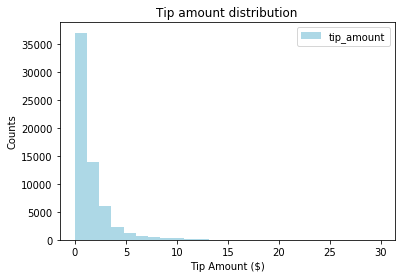

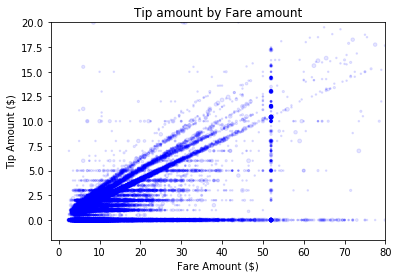

In [4]:
# data exploration & visualization

sqlStatement = """
    SELECT fare_amount, passenger_count, tip_amount, tipped FROM taxi_train
"""
sqlResultsPD = spark.sql(sqlStatement).sample(False, 0.5, seed=1234).toPandas();

%matplotlib inline
# tip by payment type & passenger count
ax1 = sqlResultsPD[['tip_amount']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Tip amount distribution')
ax1.set_xlabel('Tip Amount ($)'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

# tip by fare amount (scaled)
ax = sqlResultsPD.plot(kind='scatter', x= 'fare_amount', y = 'tip_amount', c='blue', alpha = 0.10, s=2.5*(sqlResultsPD.passenger_count))
ax.set_title('Tip amount by Fare amount')
ax.set_xlabel('Fare Amount ($)'); ax.set_ylabel('Tip Amount ($)');
plt.axis([-2, 80, -2, 20])
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

In [5]:
## feature engineering

# create buckets for traffic times
sqlStatement = """ SELECT *, CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_train 
"""
taxi_df_train_with_newFeatures = spark.sql(sqlStatement)

In [6]:
# define the transformations
sI1 = StringIndexer(inputCol="vendor_id", outputCol="vendorIndex"); en1 = OneHotEncoder(dropLast=False, inputCol="vendorIndex", outputCol="vendorVec");
sI2 = StringIndexer(inputCol="rate_code", outputCol="rateIndex"); en2 = OneHotEncoder(dropLast=False, inputCol="rateIndex", outputCol="rateVec");
sI3 = StringIndexer(inputCol="payment_type", outputCol="paymentIndex"); en3 = OneHotEncoder(dropLast=False, inputCol="paymentIndex", outputCol="paymentVec");
sI4 = StringIndexer(inputCol="TrafficTimeBins", outputCol="TrafficTimeBinsIndex"); en4 = OneHotEncoder(dropLast=False, inputCol="TrafficTimeBinsIndex", outputCol="TrafficTimeBinsVec");

# apply transformations
encodedFinal = Pipeline(stages=[sI1, en1, sI2, en2, sI3, en3, sI4, en4]).fit(taxi_df_train_with_newFeatures).transform(taxi_df_train_with_newFeatures)

In [7]:
trainingFraction = 0.5; testingFraction = (1-trainingFraction);
seed = 1234;
encodedFinalSampled = encodedFinal.sample(False, 0.5, seed=seed)

# split the data in train/test
trainData, testData = encodedFinalSampled.randomSplit([trainingFraction, testingFraction], seed=seed);

# cache dataframes in memory
trainData.cache(); trainData.count();
testData.cache(); testData.count();

Area under ROC = 0.9859923307641736


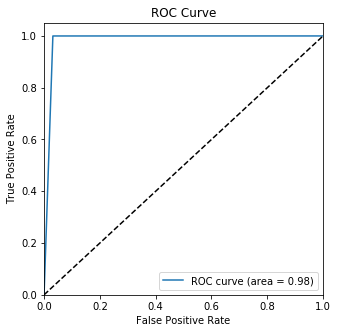

In [8]:
## Binary classification model training: Predicting tip or no tip (target: tipped = 1/0)

# define model
logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# define training formula
classFormula = RFormula(formula="tipped ~ pickup_hour + weekday + passenger_count + trip_time_in_secs + trip_distance + fare_amount + vendorVec + rateVec + paymentVec + TrafficTimeBinsVec")

# train pipeline model
model = Pipeline(stages=[classFormula, logReg]).fit(trainData)

# save model
datestamp = str(datetime.datetime.now()).replace(' ','').replace(':','_');
fileName = "logisticRegModel_" + datestamp;
logRegDirfilename = modelDir + fileName;
model.save(logRegDirfilename)

# predict on test & evaluate
predictions = model.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

# plot the ROC curve
%matplotlib inline
predictions_pddf = predictions.toPandas()
labels = predictions_pddf["label"]
prob = []
for dv in predictions_pddf["probability"]:
    prob.append(dv.values[1])
    
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');
plt.title('ROC Curve'); plt.legend(loc="lower right");
plt.show()

RMSE = 0.9697646133252147
R-sqr = 0.6918192402490602


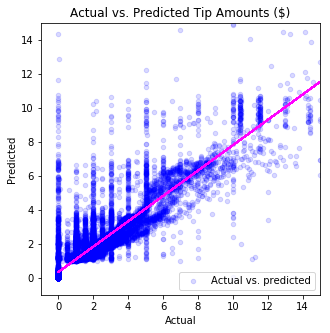

In [9]:
## Regression model training: Predicting amount of tip paid for taxi trips

# define the formula
regFormula = RFormula(formula="tip_amount ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex + pickup_hour + weekday + passenger_count + trip_time_in_secs + trip_distance + fare_amount")

# define feature indexer
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=32)

# define the model
randForest = RandomForestRegressor(featuresCol = 'indexedFeatures', labelCol = 'label', numTrees=20, 
                                   featureSubsetStrategy="auto",impurity='variance', maxDepth=6, maxBins=100)

# fit the model
model = Pipeline(stages=[regFormula, featureIndexer, randForest]).fit(trainData)

# save model
datestamp = str(datetime.datetime.now()).replace(' ','').replace(':','_');
fileName = "RandomForestRegressionModel_" + datestamp;
randForestDirfilename = modelDir + fileName;
model.save(randForestDirfilename)

# predict on test & evaluate
predictions = model.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd
testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

# plot actuals vs predictions
predictionsPD = predictions.select("label","prediction").toPandas()

ax = predictionsPD.plot(kind='scatter', figsize = (5,5), x='label', y='prediction', color='blue', alpha = 0.15, label='Actual vs. predicted');
fit = np.polyfit(predictionsPD['label'], predictionsPD['prediction'], deg=1)
ax.set_title('Actual vs. Predicted Tip Amounts ($)')
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted");
ax.plot(predictionsPD['label'], fit[0] * predictionsPD['label'] + fit[1], color='magenta')
plt.axis([-1, 15, -1, 15])
plt.show(ax)

In [10]:
# load a pipeline model and evaluate it test data

savedModel = PipelineModel.load(logRegDirfilename)

predictions = savedModel.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd

metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.9859923307641736


In [11]:
## Hyper-parameter tuning: Train a random forest model using hyper-parameter tuning and cross-validation

# define model
randForest = RandomForestRegressor(featuresCol = 'indexedFeatures', labelCol = 'label', 
                                   featureSubsetStrategy="auto",impurity='variance', maxBins=100)

# define pipeline
pipeline = Pipeline(stages=[regFormula, featureIndexer, randForest])

# define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(randForest.numTrees, [10, 25, 50]) \
    .addGrid(randForest.numTrees, [3, 5, 7]) \
    .build()

# define cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse"),
                          numFolds=3)

# train model using CV
cvModel = crossval.fit(trainData)

# predict & evaluate on test
predictions = cvModel.transform(testData)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)

# save the best model
fileName = "CV_RandomForestRegressionModel_" + datestamp;
CVDirfilename = modelDir + fileName;
cvModel.bestModel.save(CVDirfilename);

R-squared on test data = 0.769247


In [12]:
## Load independent validation data-set and evaluate a model

# read the data
taxi_valid_df = spark.read.csv(path=taxi_valid_file_loc, header=True, inferSchema=True)

# clean & normalize the data
taxi_df_valid_cleaned = taxi_valid_df.drop('medallion').drop('hack_license').drop('store_and_fwd_flag').drop('pickup_datetime')\
    .drop('dropoff_datetime').drop('pickup_longitude').drop('pickup_latitude').drop('dropoff_latitude')\
    .drop('dropoff_longitude').drop('tip_class').drop('total_amount').drop('tolls_amount').drop('mta_tax')\
    .drop('direct_distance').drop('surcharge')\
    .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') \
        AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 200 \
        AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200")

# register df as temp-table
taxi_df_valid_cleaned.createOrReplaceTempView("taxi_valid")

# create buckets for traffic times
sqlStatement = """ SELECT *, CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_valid
"""
taxi_df_valid_with_newFeatures = spark.sql(sqlStatement)

# apply the transformation on original data
encodedFinalValid = Pipeline(stages=[sI1, en1, sI2, en2, sI3, en3, sI4, en4]).fit(taxi_df_train_with_newFeatures).transform(taxi_df_valid_with_newFeatures)

In [13]:
# load model, score on validation & evaluate
savedModel = PipelineModel.load(CVDirfilename)
predictions = savedModel.transform(encodedFinalValid)
r2 = evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)

R-squared on test data = 0.786824
